# Các Scripts sử dụng cho việc trực quan GMM
- GMM với 2 cụm trên không gian LSA 2 chiều: `scripts/density_gmm_2clus.py`.
- GMM với 3 cụm trên không gian LSA 2 chiều: `scripts/density_gmm_3clus.py`.
- GMM trong không gian 3 chiều động với LSA sử dụng package `plotly`: `scripts/gmm_plotly.py`.


Cluster Distribution:
cluster
0    13176
1    10064
Name: count, dtype: int64


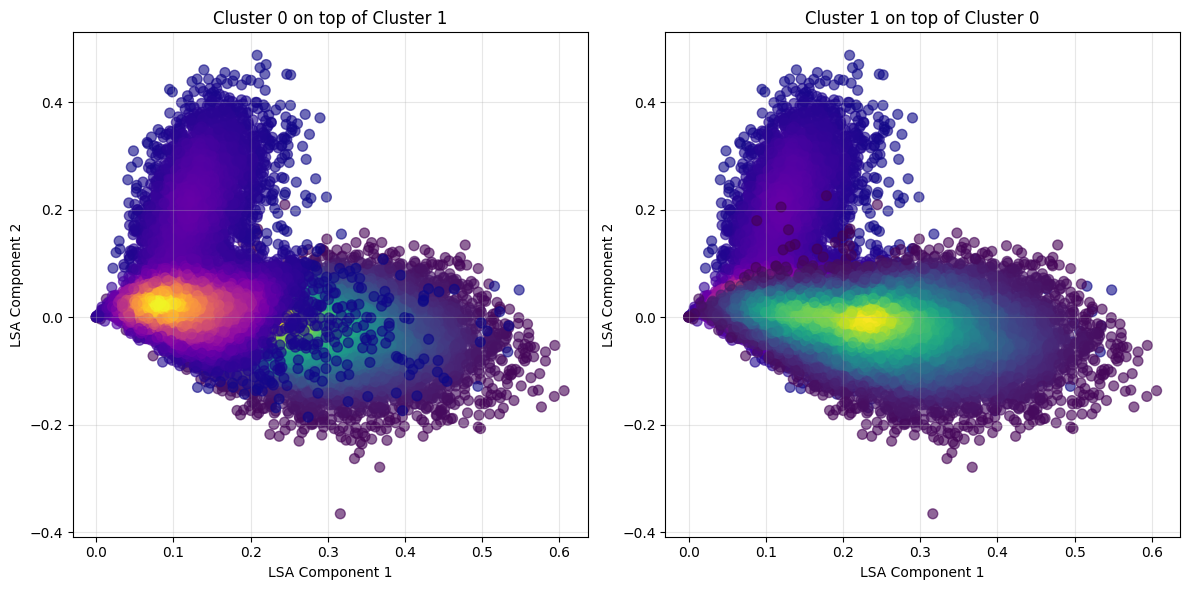

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

cleaned_corpus = pd.read_csv('data/cleaned_mhc.csv')

tfidf = TfidfVectorizer(max_features=3500)
tfidf_matrix = tfidf.fit_transform(cleaned_corpus['text'])

n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
cleaned_corpus['cluster'] = gmm.fit_predict(tfidf_matrix.toarray())

lsa = TruncatedSVD(n_components=2, random_state=42)
doc_coords = lsa.fit_transform(tfidf_matrix)


def create_density_plots(doc_coords, labels):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    colors = ['viridis', 'plasma'] 

    mask0 = labels == 0
    mask1 = labels == 1

    cluster0_points = doc_coords[mask0]
    cluster1_points = doc_coords[mask1]

    xy0 = np.vstack([cluster0_points[:, 0], cluster0_points[:, 1]])
    density0 = gaussian_kde(xy0)(xy0)
    density0 = (density0 - density0.min()) / (density0.max() - density0.min())

    xy1 = np.vstack([cluster1_points[:, 0], cluster1_points[:, 1]])
    density1 = gaussian_kde(xy1)(xy1)
    density1 = (density1 - density1.min()) / (density1.max() - density1.min())

    axs[0].scatter(
        cluster0_points[:, 0],
        cluster0_points[:, 1],
        c=density0,
        cmap=colors[0],
        s=50,
        alpha=0.6
    )
    axs[0].scatter(
        cluster1_points[:, 0],
        cluster1_points[:, 1],
        c=density1,
        cmap=colors[1],
        s=50,
        alpha=0.6
    )
    axs[0].set_title('Cluster 0 on top of Cluster 1')
    axs[0].grid(True, alpha=0.3)

    axs[1].scatter(
        cluster1_points[:, 0],
        cluster1_points[:, 1],
        c=density1,
        cmap=colors[1],
        s=50,
        alpha=0.6
    )
    axs[1].scatter(
        cluster0_points[:, 0],
        cluster0_points[:, 1],
        c=density0,
        cmap=colors[0],
        s=50,
        alpha=0.6
    )
    axs[1].set_title('Cluster 1 on top of Cluster 0')
    axs[1].grid(True, alpha=0.3)

    for ax in axs:
        ax.set_xlabel('LSA Component 1')
        ax.set_ylabel('LSA Component 2')

    plt.tight_layout()
    return plt


plt.style.use('default')
plot = create_density_plots(doc_coords, cleaned_corpus['cluster'])

print("\nCluster Distribution:")
print(cleaned_corpus['cluster'].value_counts())

plt.show()


Cluster Distribution:
cluster
0    12031
2     9183
1     2026
Name: count, dtype: int64

Model Information:
Converged: True
Number of iterations: 18
Lower bound: 11489.90


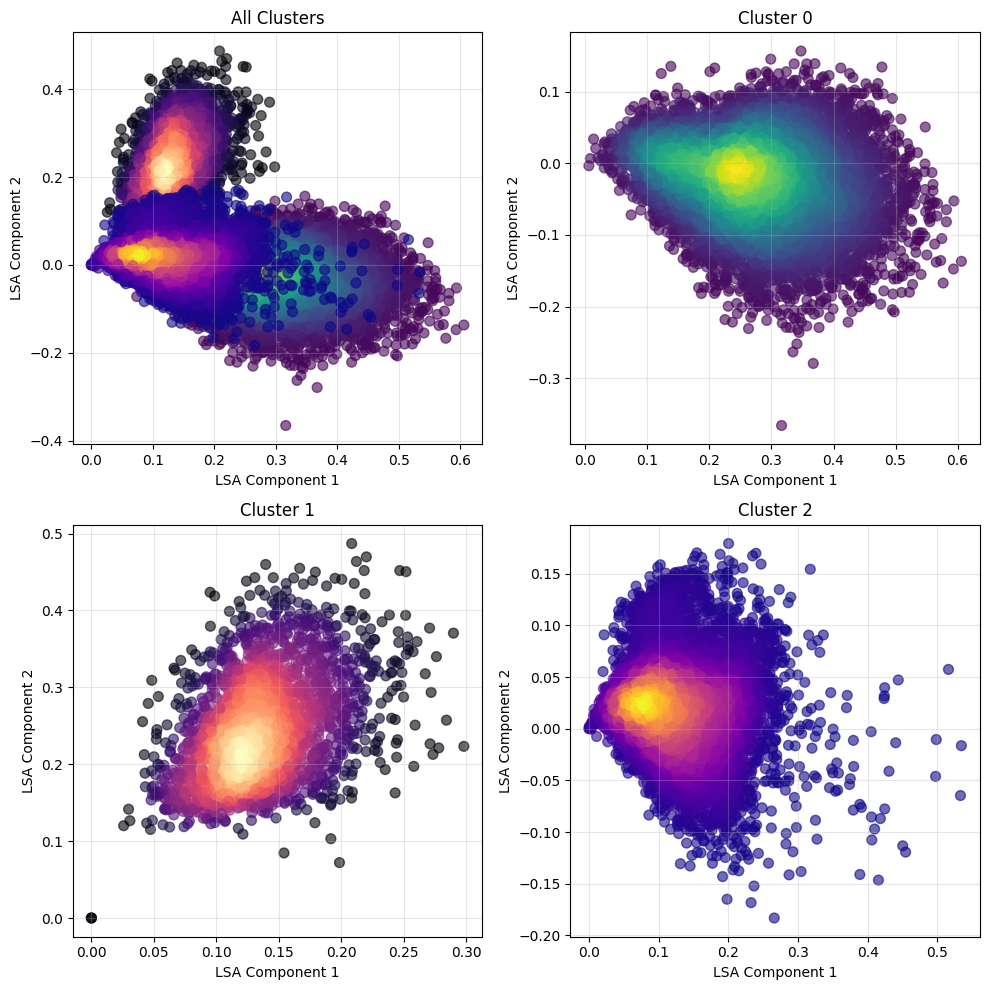

In [2]:
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
cleaned_corpus['cluster'] = gmm.fit_predict(tfidf_matrix.toarray()) 
cluster_probabilities = gmm.predict_proba(tfidf_matrix.toarray())

lsa = TruncatedSVD(n_components=2, random_state=42)
doc_coords = lsa.fit_transform(tfidf_matrix)

def create_multi_density_plots(doc_coords, labels, probabilities):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    colors = ['viridis', 'magma', 'plasma']

    axs = axs.flatten()

    for i in range(n_clusters):
        mask = labels == i
        cluster_points = doc_coords[mask]
        cluster_probs = probabilities[mask][:, i]

        xy = np.vstack([cluster_points[:, 0], cluster_points[:, 1]])
        density = gaussian_kde(xy)(xy)
        density = (density - density.min()) / (density.max() - density.min())

        combined_intensity = (density + cluster_probs) / 2

        axs[0].scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            c=combined_intensity,
            cmap=colors[i],
            s=50,
            alpha=0.6
        )

    axs[0].set_title('All Clusters')
    axs[0].grid(True, alpha=0.3)

    for i in range(n_clusters):
        mask = labels == i
        cluster_points = doc_coords[mask]
        cluster_probs = probabilities[mask][:, i]

        xy = np.vstack([cluster_points[:, 0], cluster_points[:, 1]])
        density = gaussian_kde(xy)(xy)
        density = (density - density.min()) / (density.max() - density.min())

        combined_intensity = (density + cluster_probs) / 2

        axs[i + 1].scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            c=combined_intensity,
            cmap=colors[i],
            s=50,
            alpha=0.6
        )
        axs[i + 1].set_title(f'Cluster {i}')
        axs[i + 1].grid(True, alpha=0.3)

    for ax in axs:
        ax.set_xlabel('LSA Component 1')
        ax.set_ylabel('LSA Component 2')

    plt.tight_layout()
    return plt


plt.style.use('default')
plot = create_multi_density_plots(doc_coords, cleaned_corpus['cluster'], cluster_probabilities)

print("\nCluster Distribution:")
print(cleaned_corpus['cluster'].value_counts())

print("\nModel Information:")
print(f"Converged: {gmm.converged_}")
print(f"Number of iterations: {gmm.n_iter_}")
print(f"Lower bound: {gmm.lower_bound_:.2f}")

plt.show()